In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2023-09-29 10:28:46,033	INFO worker.py:1636 -- Started a local Ray instance.


1.3624486320346218e-17 sr
	Flux for wavelength 8.130e-07 m: 3.998e+08 ph / (s m2)
	Flux for wavelength 8.250e-07 m: 3.840e+08 ph / (s m2)
	Flux for wavelength 8.370e-07 m: 3.691e+08 ph / (s m2)
Total flux: 1.153e+09 ph / (s m2)


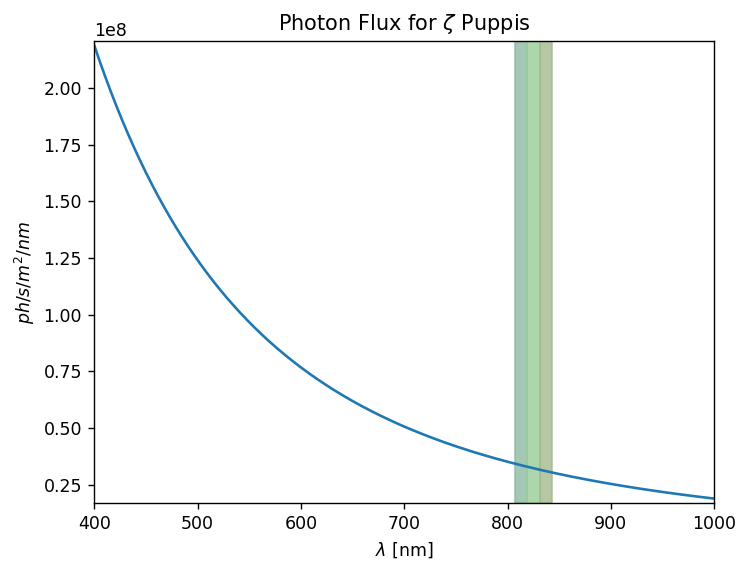

In [2]:
reload(cgi_phasec_poppy.source_flux)

wavelength_c = 825e-9*u.m

nwaves = 3
bandwidth = 2.9/100
minwave = wavelength_c * (1 - bandwidth/2)
maxwave = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minwave, maxwave, nwaves )

minlam = 400*u.nm
maxlam = 1000*u.nm
nlam = int((maxlam-minlam).value*20) + 1
lambdas = np.linspace(minlam, maxlam, nlam)

from astropy.constants import h, c, k_B, R_sun

zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=40000*u.K,
                                            distance=300*u.parsec,
                                            diameter=2*14*R_sun,
                                            name='$\zeta$ Puppis', 
                                            lambdas=lambdas,
                                           )

zpup.plot_spectrum_ph()
source_fluxes = zpup.calc_fluxes()
total_flux = np.sum(source_fluxes)

for i,flux in enumerate(source_fluxes):
    print(f'\tFlux for wavelength {wavelengths[i]:.3e}: {flux:.3e}')
print(f'Total flux: {total_flux:.3e}')

In [3]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

kwargs = {
    'cgi_mode':'spc-wide',
    'npsf':150,
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':0,
}

actors = []
for i in range(nwaves):
    actors.append(rayCGI.options(num_cpus=2, num_gpus=1/8).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])
    actors[i].setattr.remote('source_flux', source_fluxes[i])

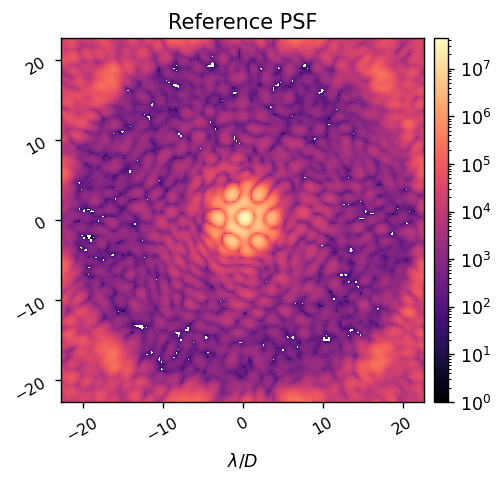

43701864.0


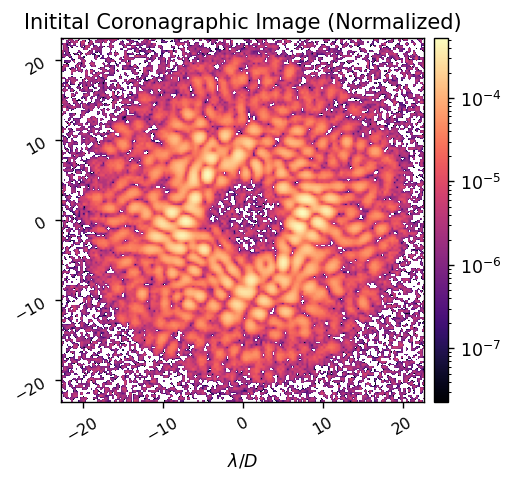

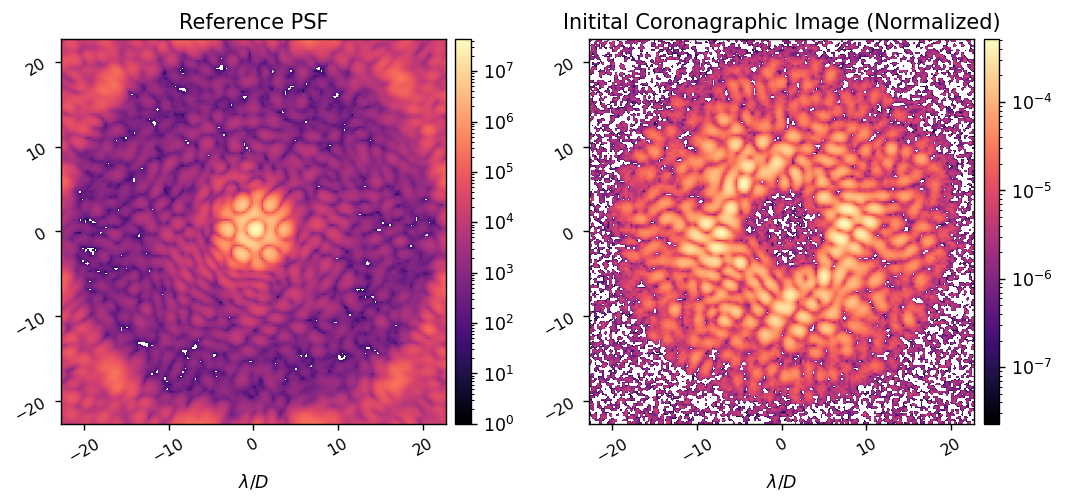

In [4]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

mode.use_noise = True
mode.exp_time = 2*u.s
mode.gain = 1
mode.dark_current_rate = 0.05*u.electron/u.pix/u.hour
# mode.dark_current_rate = 0.0*u.electron/u.pix/u.hour
mode.read_noise = 120*u.electron/u.pix
# mode.read_noise = 0*u.electron/u.pix

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, 'Reference PSF',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = xp.max(ref_unocc_im)
print(max_ref)

mode.set_actor_attr('use_fpm',True)
mode.Imax_ref = max_ref
mode.exp_time_ref = mode.exp_time
mode.gain_ref = mode.gain

mode.exp_time = 2*u.s
mode.gain = 1

ref_im = mode.snap()
imshow1(ref_im, 'Initital Coronagraphic Image (Normalized)', 
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

imshow2(ref_unocc_im, ref_im, 'Reference PSF', 'Initital Coronagraphic Image (Normalized)', 
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, 
        # save_fig='test_bb_ims.png', 
        )

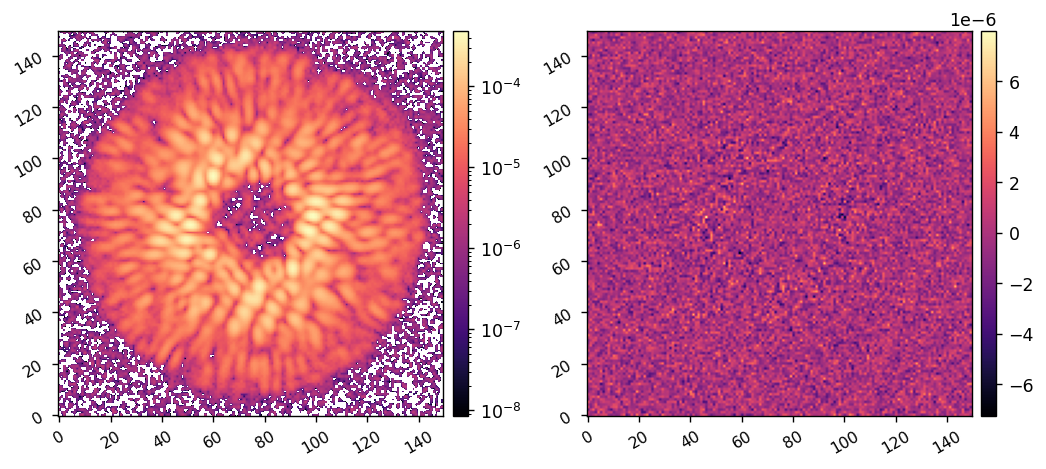

In [8]:
mode.exp_time = 2*u.s
mode.gain = 1
new_im = mode.snap()
imshow2(new_im, ref_im - new_im, lognorm1=True)

# Create dark hole ROI to calibrate and control

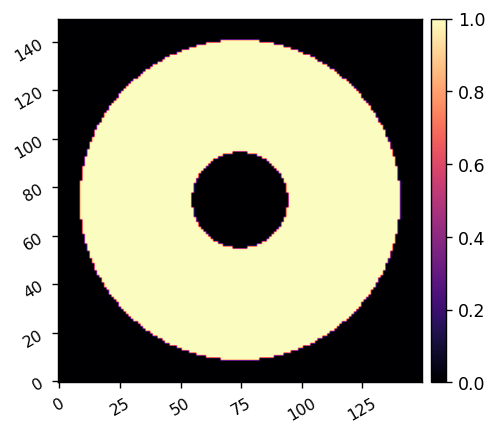

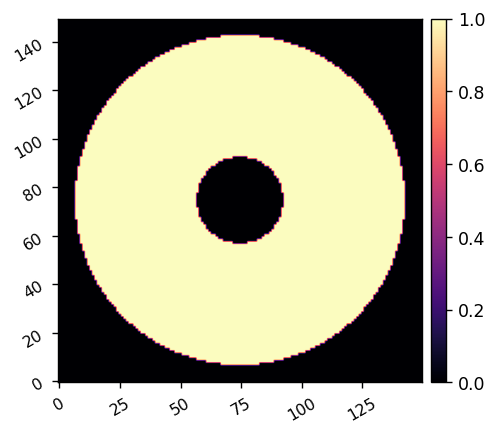

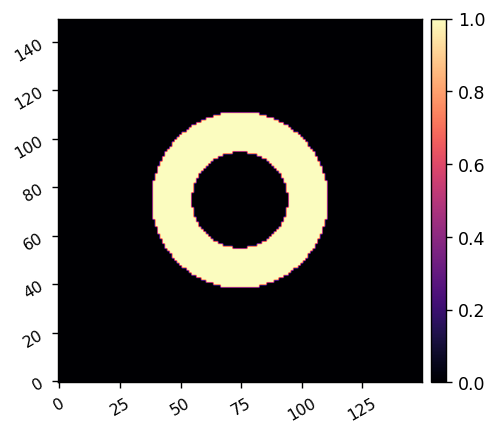

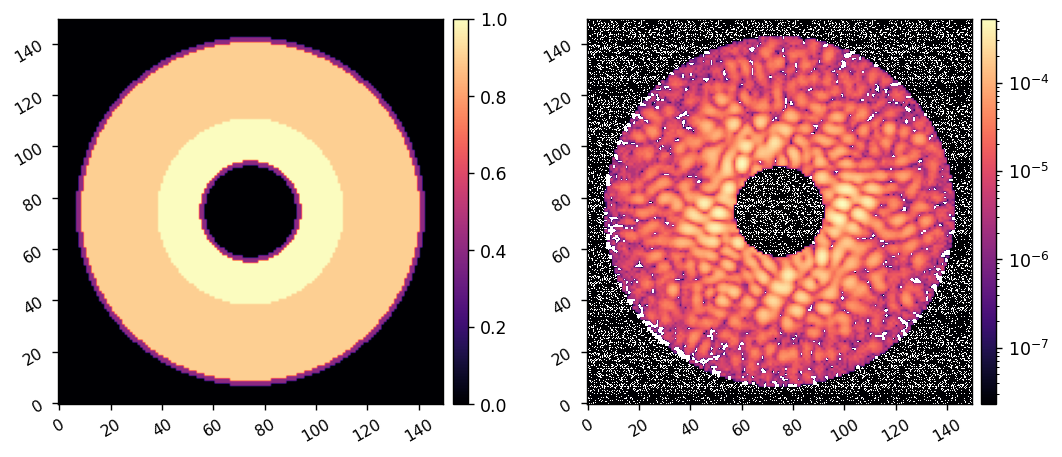

3.0467593082235417e-05


In [5]:
reload(utils)
roi1 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=20, edge=None, plot=True)
roi2 = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)
roi3 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=11, edge=None, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

# Create calibration and probe modes

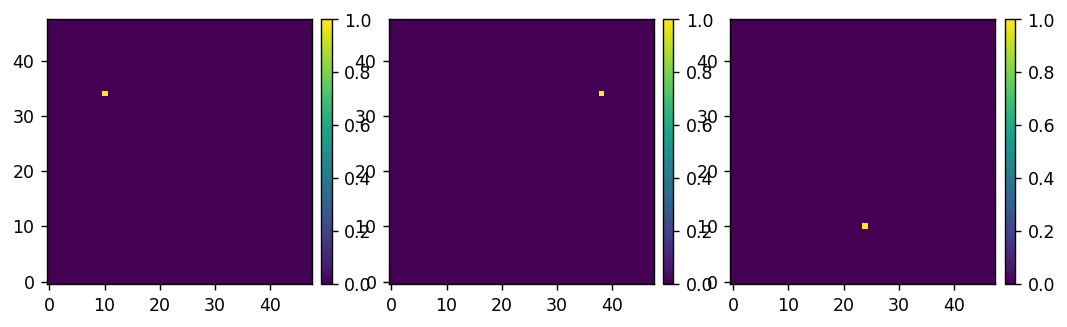

In [6]:
probe_amp = 2.5e-8
probe_modes = utils.create_poke_probes([(10,34), (38,34), (24,10)], plot=True)
# probe_modes = utils.create_poke_probes([(10,34), (10,35), (9, 34)], plot=True)

(3608, 4608)


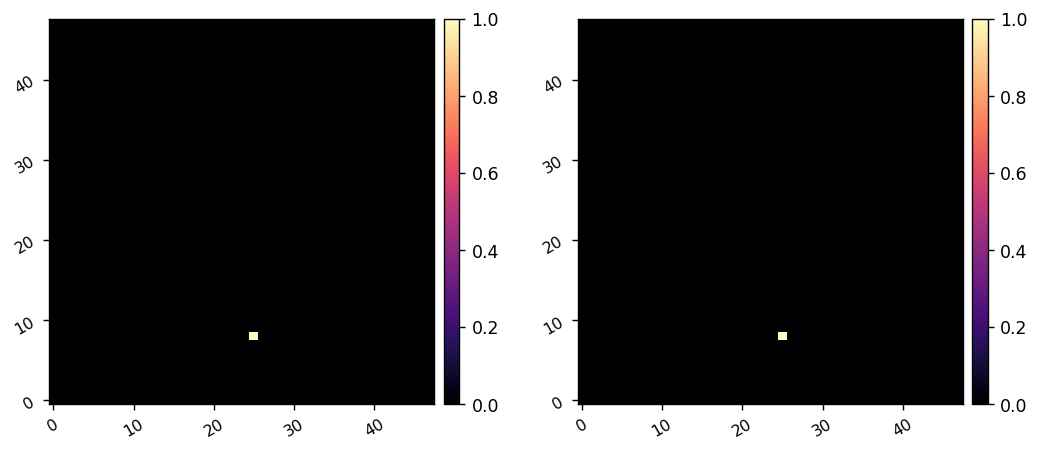

In [7]:
calib_amp = 10e-9
calib_modes = utils.create_all_poke_modes(mode.dm_mask, ndms=2)
Nmodes = calib_modes.shape[0]
print(calib_modes.shape)
i = 215
imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), calib_modes[i+mode.Nacts,mode.Nact**2:].reshape(mode.Nact,mode.Nact))


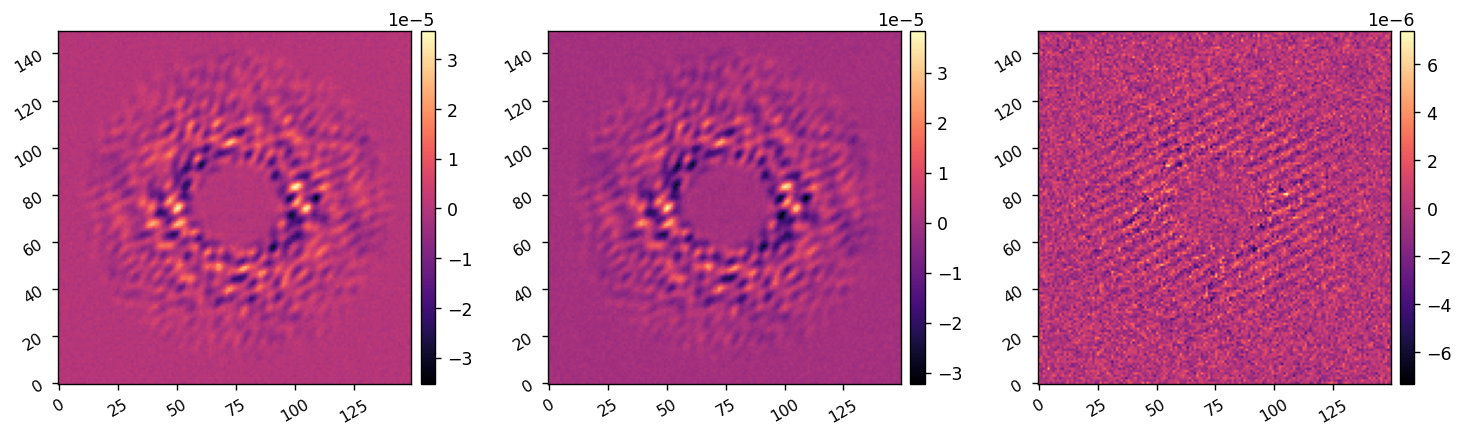

In [10]:
mode.exp_time = 10*u.s
mode.gain = 1

calib_amp = 20e-9

mode.add_dm1(calib_amp * calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))
mode.add_dm1(probe_amp * probe_modes[0])
im1 = mode.snap()
mode.add_dm1(-2*probe_amp * probe_modes[0])
im2 = mode.snap()
mode.add_dm1(probe_amp * probe_modes[0])

mode.add_dm1(-2*calib_amp * calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))
mode.add_dm1(probe_amp * probe_modes[0])
im3 = mode.snap()
mode.add_dm1(-2*probe_amp * probe_modes[0])
im4 = mode.snap()
mode.add_dm1(probe_amp * probe_modes[0])
mode.add_dm1(calib_amp * calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact))

del1 = im1-im2
del2 = im3-im4

deldel = del1 - del2

imshow3(del1, del2, deldel)

In [88]:
mode.reset_dms()

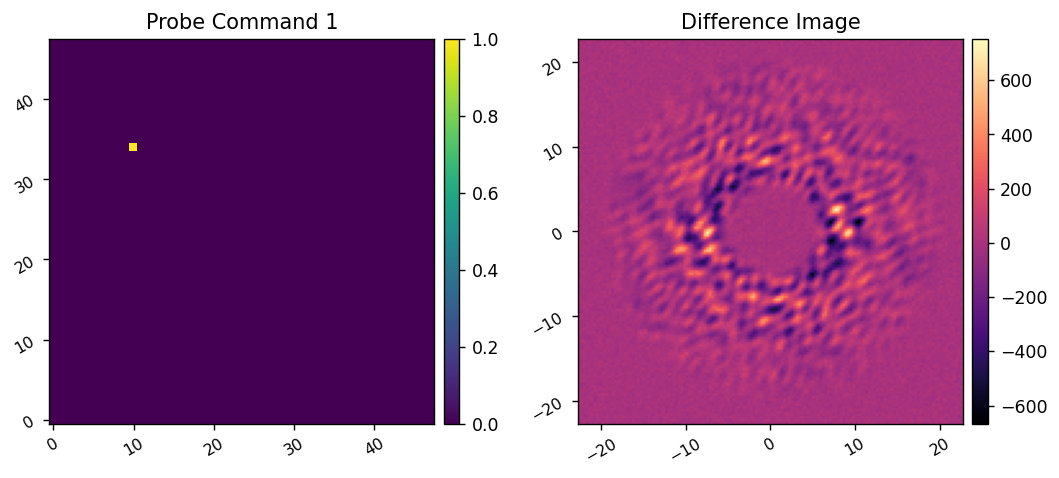

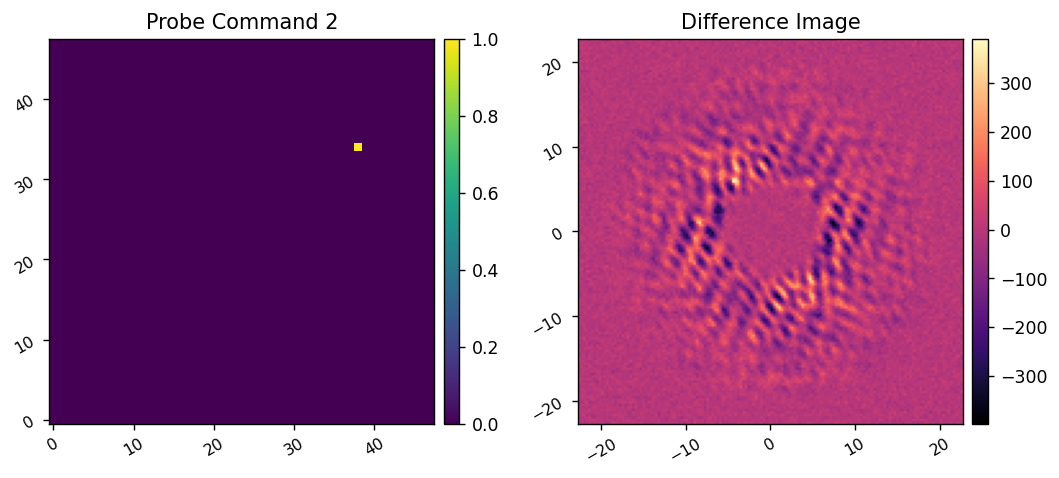

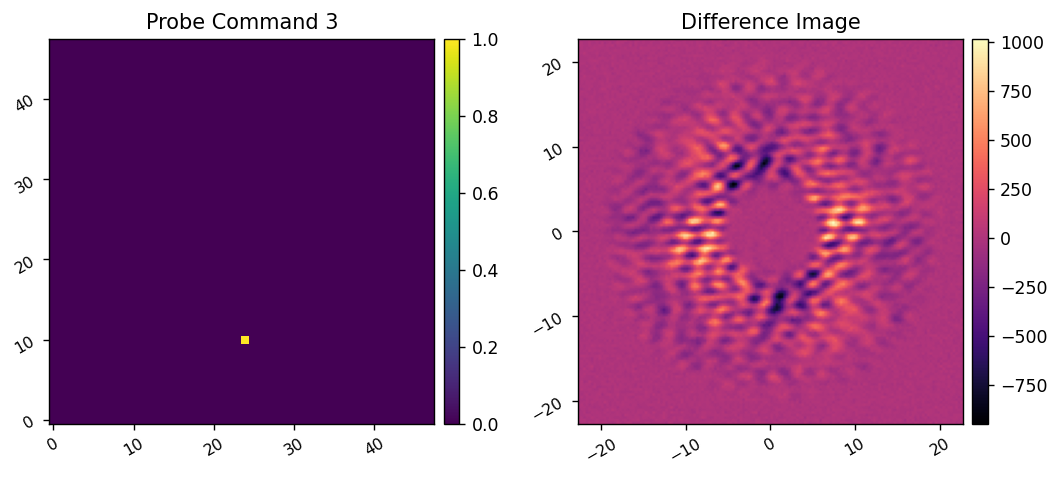

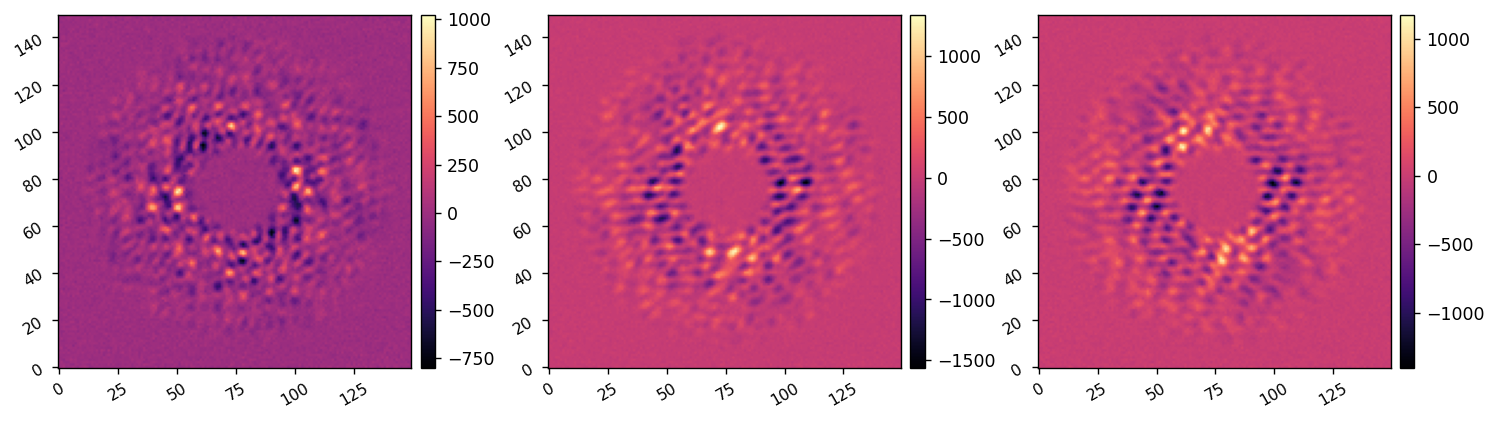

In [11]:
reload(iefc_2dm)

differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True, plot=True)
ims = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)
imshow3(ims[0]-ims[1], ims[0]-ims[2], ims[1]-ims[2])

Calibrating iEFC...
	Calibrated mode 2/2 in 4.611s
Calibration complete.


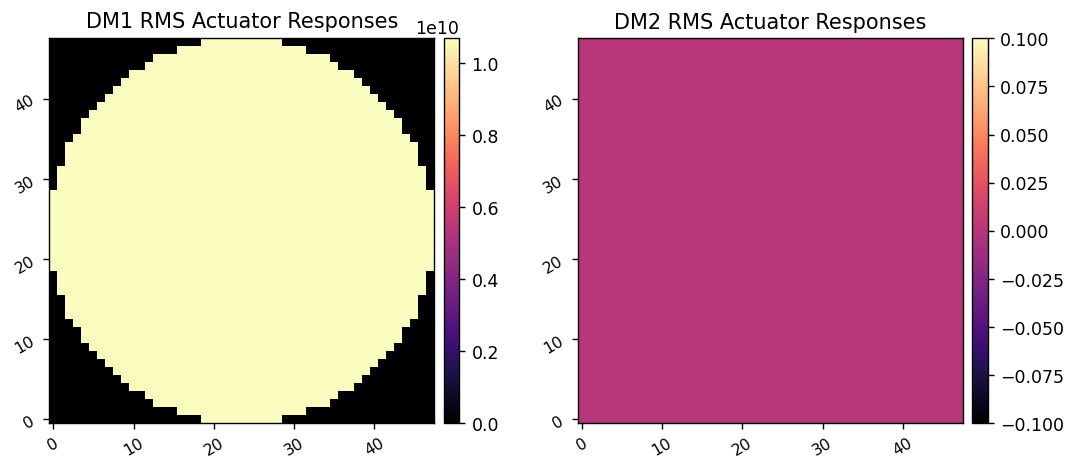

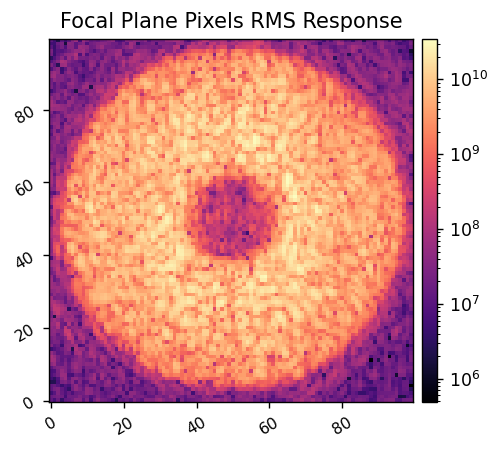

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/test_response_matrix_20230912.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/test_response_cube_20230912.fits


In [13]:
reload(iefc_2dm)

calib_amp = 5e-9

response_matrix, response_cube = iefc_2dm.calibrate(mode, 
                                                    control_mask,
                                                    probe_amp, probe_modes, 
                                                     calib_amp, calib_modes[:2], 
                                                     return_all=True, 
#                                                     plot_responses=False,
                                                   )

utils.save_fits(response_dir/f'test_response_matrix_{today}.fits', response_matrix)
utils.save_fits(response_dir/f'test_response_cube_{today}.fits', response_cube)


In [10]:
date = 20230912
date = 20230913
date = 20230918
date = 20230920
# date = 20230921
response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_825_poke_modes_response_matrix_{date}.fits'))
response_cube = xp.array(fits.getdata(data_dir/response_dir/f'spc_wide_825_poke_modes_response_cube_{date}.fits'))

In [21]:
xp.mean(response_matrix.dot(xp.array(calib_modes)), axis=0).shape

(4608,)

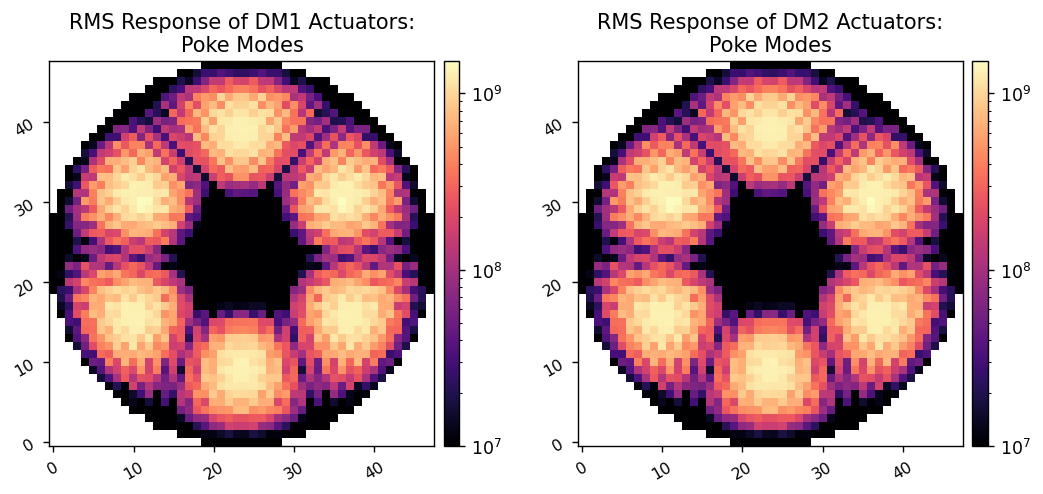

In [27]:
response_matrix.shape

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)
dm2_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1 Actuators:\nPoke Modes', 'RMS Response of DM2 Actuators:\nPoke Modes',
        lognorm=True, vmin1=1e7, vmin2=1e7,
        )


# Run IEFC

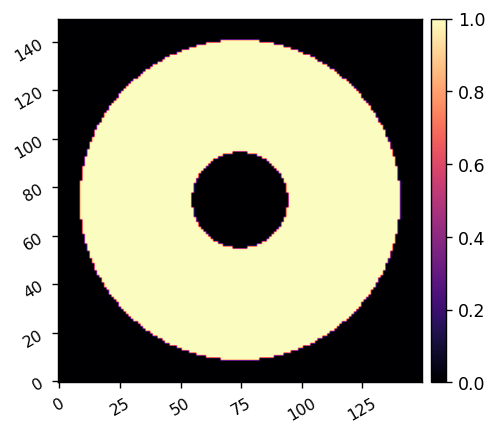

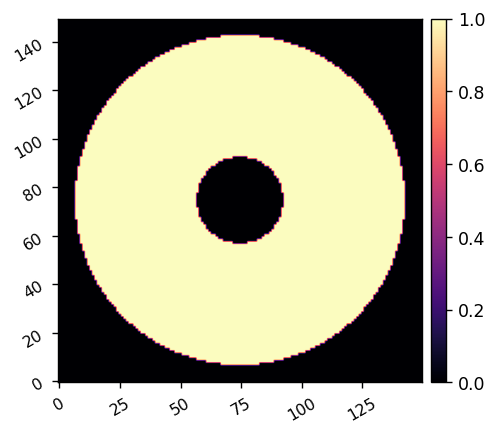

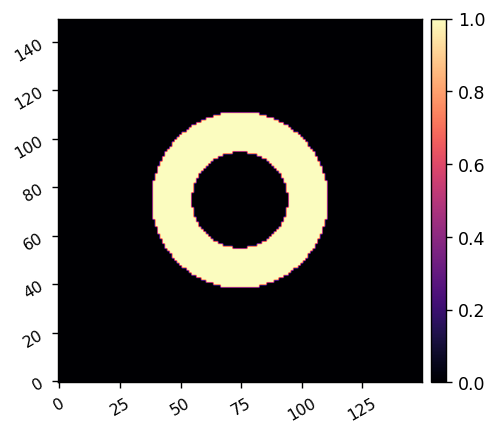

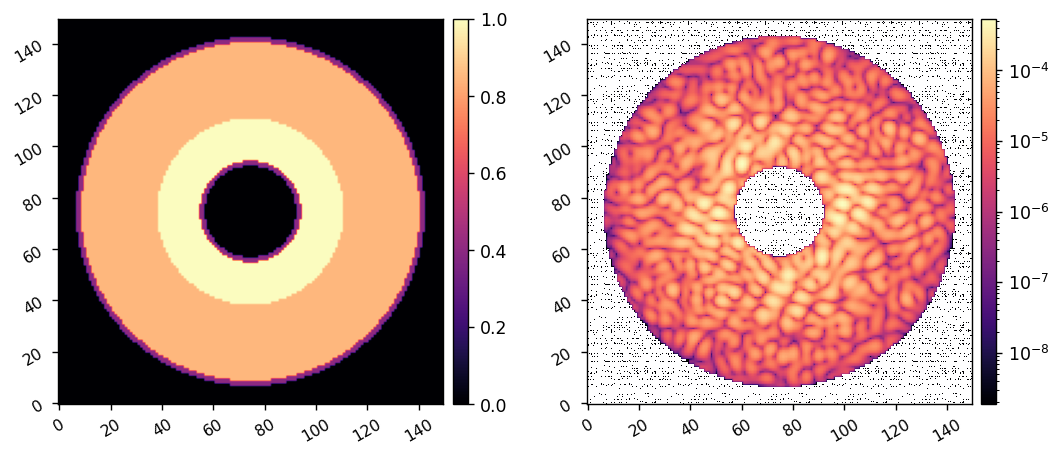

3.042688486608366e-05


In [99]:
reload(utils)
roi1 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=20, edge=None, plot=True)
roi2 = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)
roi3 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=11, edge=None, plot=True)

relative_weight_1 = 0.85
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

In [100]:
mode.reset_dms()

In [101]:
images = xp.array([ref_im])
dm1_commands = xp.array([mode.get_dm1()])
dm2_commands = xp.array([mode.get_dm2()])

In [33]:
mode.set_dm1(ensure_np_array(dm1_commands[-8]))
mode.set_dm2(ensure_np_array(dm2_commands[-8]))

In [102]:
reg_cond = 1e-2/2
reg_cond = 1e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])

# probe_amp = 2e-8


Running iEFC...
	Closed-loop iteration 1 / 6
	Mean NI of this iteration: 8.458e-06


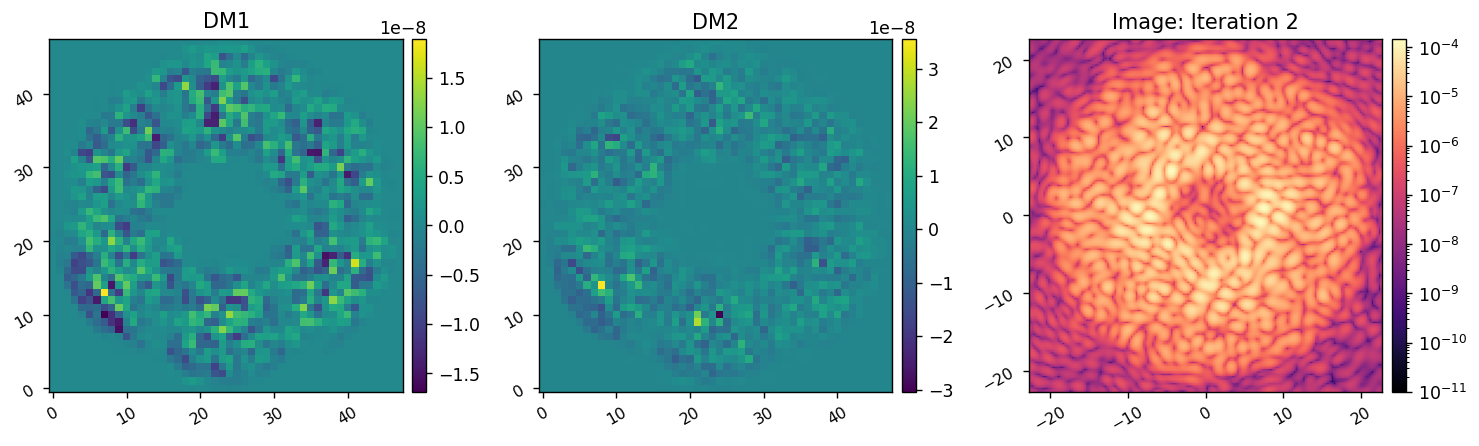

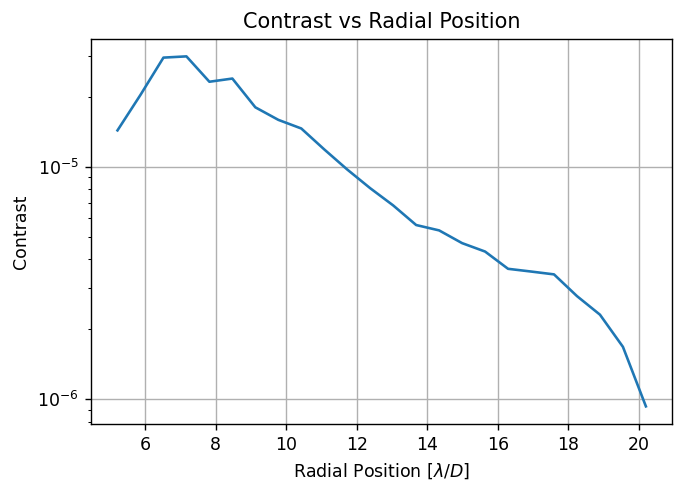

	Closed-loop iteration 2 / 6
	Mean NI of this iteration: 2.614e-06


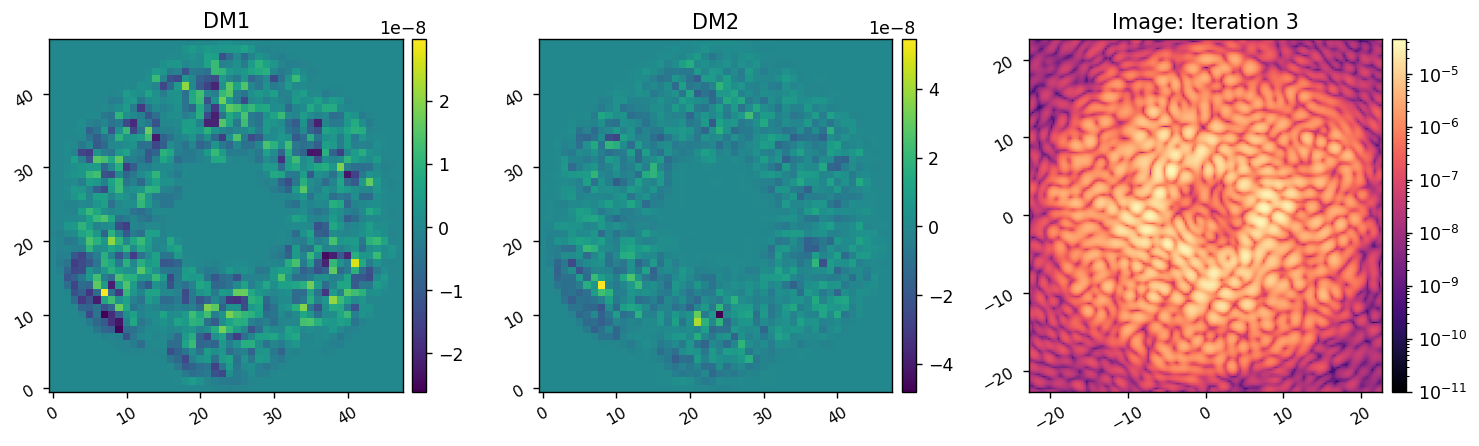

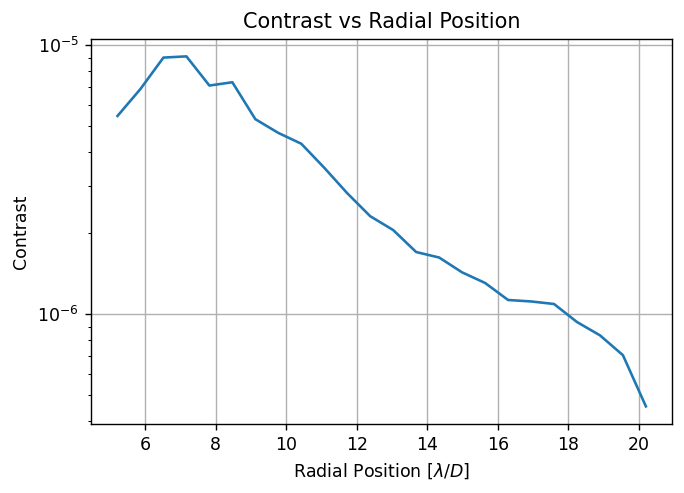

	Closed-loop iteration 3 / 6
	Mean NI of this iteration: 9.607e-07


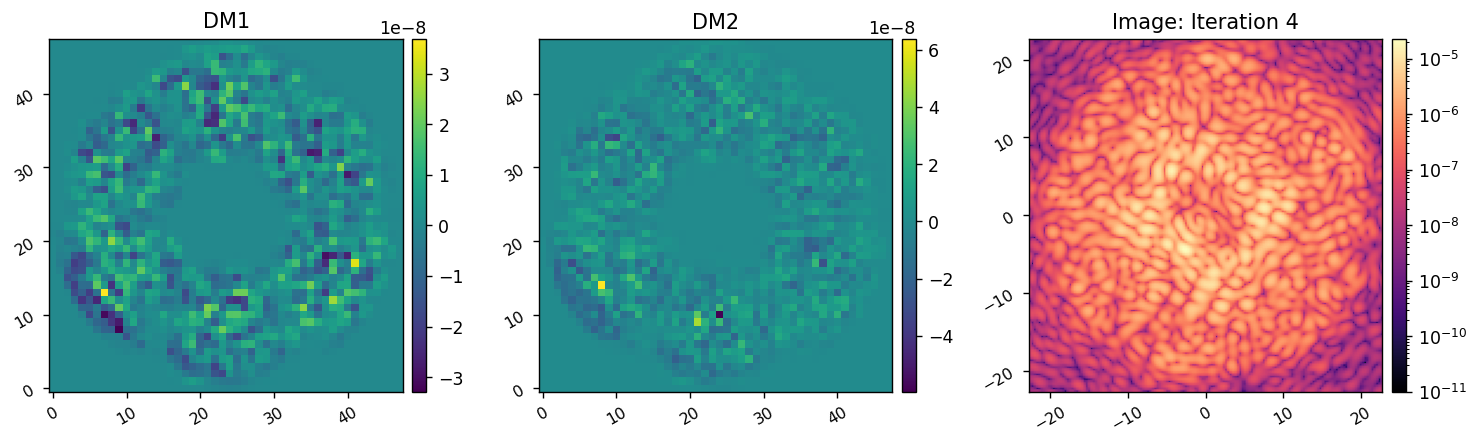

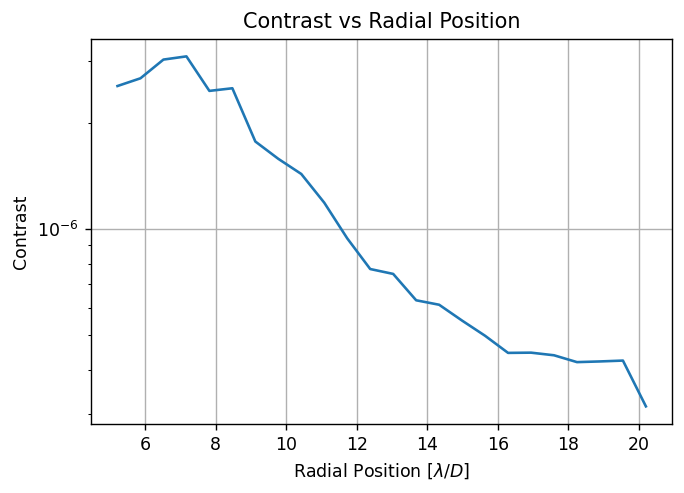

	Closed-loop iteration 4 / 6


KeyboardInterrupt: 

In [103]:
reload(iefc_2dm)
reload(utils)

images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                          control_matrix,
                                          probe_modes, 
                                          probe_amp, 
                                          calib_modes,
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0,
#                                                   use_fourier_filter=True,
                                          plot_all=True,
                                         plot_radial_contrast=True,
                                                  old_images=images,
                                                  old_dm1_commands=dm1_commands,
                                                  old_dm2_commands=dm2_commands,
                                         )